In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyvinecopulib as pv

from scipy.optimize import curve_fit
from scipy.stats import cramervonmises_2samp, ks_2samp, norm, rankdata
from sklearn.model_selection import KFold

In [2]:
# Load data
df = pd.read_excel("data_flowdike.xlsx")

# Select data with hpeak > 1cm
df = df[df['hpeak'] >= 0.01]

# Match colors
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:cyan"]
conv_dict = {expid:c for expid, c in zip(list(np.unique(df['experiment_id'])), colors)}
df['color'] = df['experiment_id'].map(conv_dict)

# Calculate dimensionless values
df['upeakd'] = df['upeak'] / np.sqrt(9.81 * df['Hm0'])
df['hpeakd'] = df['hpeak'] / df['Hm0']
df['vtd'] = df['vt'] / df['Hm0']**2

# Curve
def curve_exp(x, a, b):
    return a * x ** b

# Calculate residuals per experiment
for expid, _df in df.groupby(by="experiment_id"):

    # Fit curve
    paramu, _ = curve_fit(curve_exp, _df['vtd'], _df['upeakd'])
    paramh, _ = curve_fit(curve_exp, _df['vtd'], _df['hpeakd'])
    
    # Marginals
    ru = np.log(_df['upeakd']) - np.log(curve_exp(_df['vtd'], *paramu))
    rh = np.log(_df['hpeakd']) - np.log(curve_exp(_df['vtd'], *paramh))
    
    # Adjust
    muu, _ = norm.fit(ru)
    muh, _ = norm.fit(rh)

    # Calculate residuals
    df.loc[df['experiment_id'] == expid, 'ru'] = np.log(_df['upeakd']) - np.log(curve_exp(_df['vtd'], *paramu)) - muu
    df.loc[df['experiment_id'] == expid, 'rh'] = np.log(_df['hpeakd']) - np.log(curve_exp(_df['vtd'], *paramh)) - muh

<h1>4.1 - Copula Modeling</h1>

<h3>Residuals $r_{u}$ against $r_{h}$, color-coded by experiment</h3>

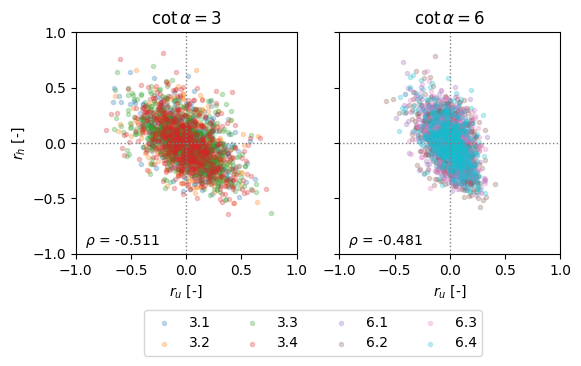

In [3]:
# Plot
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[6,3.2], sharex=True, sharey=True)

# Center lines
[ax.axvline(0.0, lw=1, ls=":", color="grey") for ax in [ax0, ax1]]
[ax.axhline(0.0, lw=1, ls=":", color="grey") for ax in [ax0, ax1]]

# Per experiment
for expid, deeldf in df.groupby(by="experiment_id"):
    ax = ax0 if deeldf['cota'].iloc[0] == 3 else ax1
    ax.scatter(deeldf['ru'], deeldf['rh'], marker='.', alpha=0.25, label=f"{expid}", color=deeldf['color'].iloc[0])

# Calculate Pearson per slope
for cota, deeldf in df.groupby(by="cota"):
    rho = np.corrcoef(deeldf['ru'], deeldf['rh'])[0,1]
    ax = ax0 if cota == 3 else ax1
    ax.text(-0.92, -0.92, r"$\rho$ = " + str(round(rho, 3)), fontsize=10)

# Plot layout
ax0.set_xlabel(r"$r_{u}$ [-]")
ax1.set_xlabel(r"$r_{u}$ [-]")
ax0.set_ylabel(r"$r_{h}$ [-]")
ax0.set_title(r"$\cot \alpha = 3$")
ax1.set_title(r"$\cot \alpha = 6$")
ax0.set_xlim(-1, 1)
ax0.set_ylim(-1, 1)

fig.legend(ncol=4, loc='lower center', bbox_to_anchor=(0.545, -0.15), prop={'size': 10})

fig.tight_layout()
fig.align_labels()
plt.show()

<h1>4.2 - Empirical Cumulative Distribution Function</h1>

<h3>Empirical Cumulative Distribution Function of the Residuals</h3>

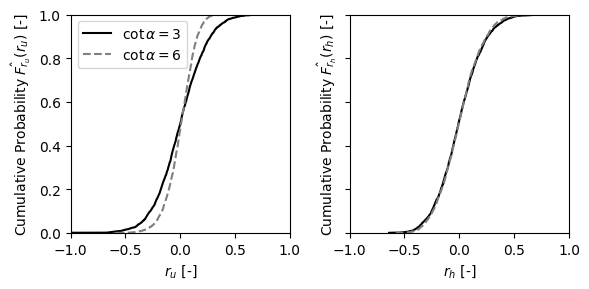

In [4]:
# Plot
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[6,3], sharex=True, sharey=True)

# Calculate the ECDF for each group
df["ecdf_u"] = df.groupby("cota")["ru"].transform(lambda x: rankdata(x, method="ordinal") / (len(x)+1))
df["ecdf_h"] = df.groupby("cota")["rh"].transform(lambda x: rankdata(x, method="ordinal") / (len(x)+1))

# Per waterside slope angle
for cota, deeldf in df.groupby(by="cota"):
    filt_deeldf = deeldf.sort_values("ru")
    ax0.plot(filt_deeldf["ru"], filt_deeldf["ecdf_u"], color="black" if cota==3 else "grey", label=r"$\cot \alpha = $" + str(round(cota)), ls="solid" if cota==3 else "--")
    filt_deeldf = deeldf.sort_values("rh")
    ax1.plot(filt_deeldf["rh"], filt_deeldf["ecdf_h"], color="black" if cota==3 else "grey", label=r"$\cot \alpha = $" + str(round(cota)), ls="solid" if cota==3 else "--")

# Plot layout
ax0.legend(loc="upper left", prop={'size': 10})
ax0.set_xlabel("$r_{u}$ [-]")
ax1.set_xlabel("$r_{h}$ [-]")
ax0.set_ylabel(r"Cumulative Probability $\hat{F_{r_{u}}}(r_{u})$ [-]")
ax1.set_ylabel(r"Cumulative Probability $\hat{F_{r_{h}}}(r_{h})$ [-]")
ax0.set_xlim(-1, 1)
ax0.set_ylim(0, 1)

fig.tight_layout()
fig.align_labels()
plt.show()

<h3>Empirical Joint Cumulative Distribution of the Residuals</h3>

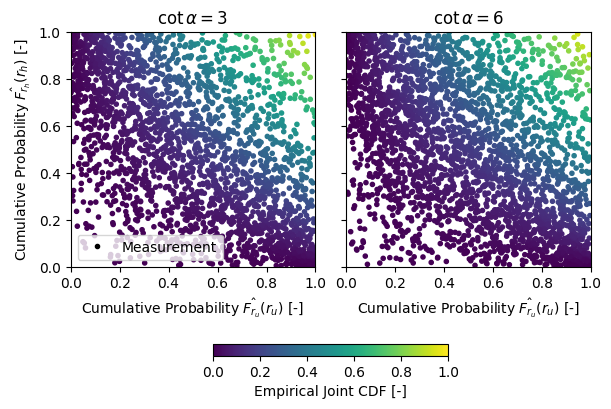

In [5]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[6,4], sharex=True, sharey=True, constrained_layout=True)

# Per cota
for cota, _df in df.groupby(by = "cota"):
    
    # Obtain data
    u  = rankdata(_df['ru'], method="ordinal")/ (len(_df['ru']) + 1)
    h  = rankdata(_df['rh'], method="ordinal")/ (len(_df['rh']) + 1)
    data = np.array([u, h]).T
    
    # Calculate CvM
    ecdf_df = pd.DataFrame(data, columns=["phiu", "phih"])
    for i, row in ecdf_df.iterrows():

        # Count rows with 'resu' <= row['resu'] and 'resh' <= row['resh']
        count = len(ecdf_df[(ecdf_df['phiu'] <= row['phiu']) & (ecdf_df['phih'] <= row['phih'])])

        # Compute the empirical CDF value
        ecdf_df.loc[i, 'cdf_empirical'] = count / len(ecdf_df)
    
    ax = ax0 if cota == 3 else ax1
    scatter = ax.scatter(u, h, c=ecdf_df["cdf_empirical"], cmap="viridis", marker=".", vmin=0, vmax=1)

# Legend
ax0.plot([-10], [-10], ".", color="black", label="Measurement")
ax0.legend(loc = "lower left", prop={'size': 10}, ncol=1)
    
# Add scatterplot labels and titles
ax0.set_xlabel(r"Cumulative Probability $\hat{F_{r_{u}}}(r_{u})$ [-]")
ax1.set_xlabel(r"Cumulative Probability $\hat{F_{r_{u}}}(r_{u})$ [-]")
ax0.set_ylabel(r"Cumulative Probability $\hat{F_{r_{h}}}(r_{h})$ [-]")
ax0.set_title(r"$\cot \alpha = 3$")
ax1.set_title(r"$\cot \alpha = 6$")
ax0.set_xlim(0, 1)
ax0.set_ylim(0, 1)

# Add horizontal colorbar
cbar = fig.colorbar(scatter, ax=[ax0, ax1], orientation="horizontal", fraction=0.05, pad=0.1)
cbar.set_label("Empirical Joint CDF [-]")

# Add legend and layout adjustments
fig.align_labels()

plt.show()

<h1>4.3 - Copula Construction</h1>

<h3>Test Copula Families</h3>

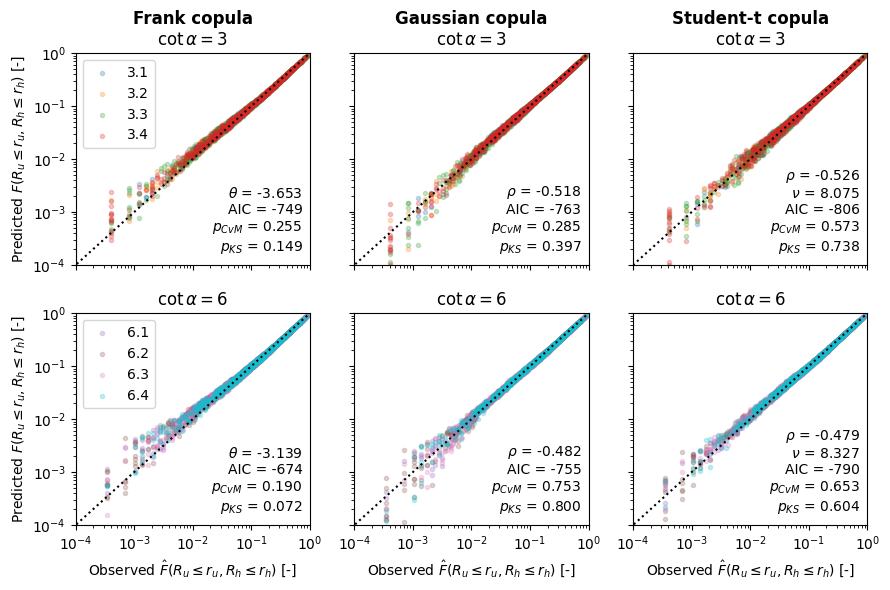

In [6]:
fig, axs = plt.subplots(2, 3, figsize=[9, 6], sharex=True, sharey=True)
axs = axs.flatten()

# Per copula family
for ic, cop in enumerate([pv.BicopFamily.frank, pv.BicopFamily.gaussian, pv.BicopFamily.student]):
    
    ax0, ax1 = axs[ic], axs[ic+3]
    
    # Per cota
    for cota, _df in df.groupby(by = "cota"):

        # Obtain data
        u  = rankdata(_df['ru'])/ (len(_df['ru']) + 1)
        h  = rankdata(_df['rh'])/ (len(_df['rh']) + 1)
        data = np.array([u, h]).T

        # Calculate CvM
        ecdf_df = pd.DataFrame(data, columns=["phiu", "phih"])
        for i, row in ecdf_df.iterrows():

            # Count rows with 'resu' <= row['resu'] and 'resh' <= row['resh']
            count = len(ecdf_df[(ecdf_df['phiu'] <= row['phiu']) & (ecdf_df['phih'] <= row['phih'])])

            # Compute the empirical CDF value
            ecdf_df.loc[i, 'cdf_empirical'] = count / len(ecdf_df)

        # Create a copula and fit data
        cop_temp = pv.Bicop(cop)
        cop_temp.fit(data = data)
        cop_cdf = cop_temp.cdf(data)
        aic = cop_temp.aic(u = data)
        cvm = cramervonmises_2samp(ecdf_df['cdf_empirical'], cop_cdf)
        ks = ks_2samp(ecdf_df['cdf_empirical'], cop_cdf)

        # Plot observed vs copula
        ax = ax0 if cota == 3 else ax1
        ecdf = ecdf_df['cdf_empirical'].to_numpy()
        for expid, deeldf2 in _df.groupby(by="experiment_id"): 

            # Plot
            ax.scatter(ecdf[_df['experiment_id'] == expid], cop_cdf[_df['experiment_id'] == expid], marker='.', label=f"{expid}", alpha=0.25, color=deeldf2['color'].iloc[0])

        # Parameters
        _params = ""
        if ic == 0:
            _params = r"$\theta$ = " + f"{round(cop_temp.parameters[0][0], 3):.3f}" + "\n"
        elif ic == 1:
            _params = r"$\rho$ = " + f"{round(cop_temp.parameters[0][0], 3):.3f}" + "\n"
        elif ic == 2:
            _params = r"$\rho$ = " + f"{round(cop_temp.parameters[0][0], 3):.3f}" + "\n"
            _params = _params + r"$\nu$ = " + f"{round(cop_temp.parameters[1][0], 3):.3f}" + "\n"
        _params = _params + f"AIC = {round(aic)}\n"
        _params = _params + r"$p_{CvM}$" + f" = {round(cvm.pvalue, 3):.3f}" + "\n"
        _params = _params + r"$p_{KS}$" + f" = {round(ks.pvalue, 3):.3f}"
        ax.text(0.75, 1.5e-4, _params, ha="right", va="bottom")
        
    cop_name = "Student-t"
    if cop == pv.BicopFamily.frank:
        cop_name = "Frank"
    elif cop is pv.BicopFamily.gaussian:
        cop_name = "Gaussian"
            
    ax0.set_title(f"{cop_name} copula\n" + r"$\cot \alpha = 3$", fontweight="bold")
    ax1.set_title(r"$\cot \alpha = 6$")

# Plot layout
axs[0].legend(loc = "upper left")
axs[3].legend(loc = "upper left")
[axs[i].plot([0, 1], [0, 1], color="black", ls=":") for i in range(len(axs))]
ax0.set_xscale("log")
ax0.set_yscale("log")
ax0.set_xlim(10e-5, 1)
ax0.set_ylim(10e-5, 1)
[axs[i].set_xlabel(r"Observed $\hat{F}(R_{u} \leq r_{u}, R_{h} \leq r_{h})$ [-]") for i in [3, 4, 5]]
[axs[i].set_ylabel(r"Predicted $F(R_{u} \leq r_{u}, R_{h} \leq r_{h})$ [-]") for i in [0, 3]]

fig.tight_layout()
fig.align_labels()
plt.show()

<h3>Define a Student-t copula independent on the waterside slope angle</h3>

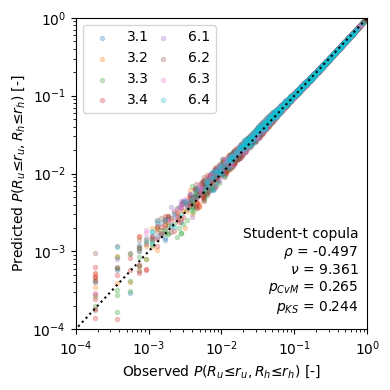

In [7]:
cop = pv.BicopFamily.student

fig, ax = plt.subplots(1, 1, figsize=[4, 4], sharex=True, sharey=True)

# Obtain data
u  = rankdata(df['ru'])/ (len(df['ru']) + 1)
h  = rankdata(df['rh'])/ (len(df['rh']) + 1)
data = np.array([u, h]).T

# Calculate CvM
ecdf_df = pd.DataFrame(data, columns=["phiu", "phih"])
for i, row in ecdf_df.iterrows():

    # Count rows with 'resu' <= row['resu'] and 'resh' <= row['resh']
    count = len(ecdf_df[(ecdf_df['phiu'] <= row['phiu']) & (ecdf_df['phih'] <= row['phih'])])

    # Compute the empirical CDF value
    ecdf_df.loc[i, 'cdf_empirical'] = count / len(ecdf_df)

# Create a copula and fit data
cop_temp = pv.Bicop(pv.BicopFamily.student)
cop_temp.fit(data = data)
cop_cdf = cop_temp.cdf(data)
cvm = cramervonmises_2samp(ecdf_df['cdf_empirical'], cop_cdf)
ks = ks_2samp(ecdf_df['cdf_empirical'], cop_cdf)

# Plot observed vs copula
ecdf = ecdf_df['cdf_empirical'].to_numpy()
for expid, deeldf2 in df.groupby(by="experiment_id"): 
    ax.scatter(ecdf[df['experiment_id'] == expid], cop_cdf[df['experiment_id'] == expid], marker='.', label=f"{expid}", alpha=0.25, color=deeldf2['color'].iloc[0])

# Parameters
_params = "Student-t copula\n"
_params = _params +  r"$\rho$ = " + f"{round(cop_temp.parameters[0][0], 3):.3f}" + "\n"
_params = _params + r"$\nu$ = " + f"{round(cop_temp.parameters[1][0], 3):.3f}" + "\n"
_params = _params + r"$p_{CvM}$" + f" = {round(cvm.pvalue, 3):.3f}" + "\n"
_params = _params + r"$p_{KS}$" + f" = {round(ks.pvalue, 3):.3f}"
ax.text(0.75, 1.5e-4, _params, ha="right", va="bottom")

# Plot layout
ax.legend(loc = "upper left", ncol=2, columnspacing=0)
ax.plot([0, 1], [0, 1], color="black", ls=":")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(10e-5, 1)
ax.set_ylim(10e-5, 1)
ax.set_xlabel(r"Observed $P(R_{u} ≤ r_{u}, R_{h} ≤ r_{h})$ [-]")
ax.set_ylabel(r"Predicted $P(R_{u} ≤ r_{u}, R_{h} ≤ r_{h})$ [-]")

fig.tight_layout()
fig.align_labels()
plt.show()

<h3>Subset testing</h3>

In [8]:
# Example data: u and v are uniform marginals from your actual data
kf = KFold(n_splits=10, shuffle=True, random_state=50)

all_data = []

# Per subset
subset_id = 1
for test_idx, _ in kf.split(df):

    # Select subset
    _df = df.iloc[test_idx]
    
    # Obtain data
    u  = rankdata(_df['ru'], method='ordinal')/ (len(_df['ru']) + 1)
    h  = rankdata(_df['rh'], method='ordinal')/ (len(_df['rh']) + 1)
    data = np.array([u, h]).T
    
    # Calculate CvM
    ecdf_df = pd.DataFrame(data, columns=["phiu", "phih"])
    for i, row in ecdf_df.iterrows():
    
        # Count rows with 'resu' <= row['resu'] and 'resh' <= row['resh']
        count = len(ecdf_df[(ecdf_df['phiu'] <= row['phiu']) & (ecdf_df['phih'] <= row['phih'])])
    
        # Compute the empirical CDF value
        ecdf_df.loc[i, 'cdf_empirical'] = count / len(ecdf_df)
    
    # Create a copula
    cop_temp = pv.Bicop.from_family(pv.BicopFamily.student, parameters=np.array([[-0.497], [9.361]]))
    
    # Calculate AIC
    aic = cop_temp.aic(u = data)
    
    # Calculate CvM
    cop_cdf = cop_temp.cdf(data)
    cvm = cramervonmises_2samp(ecdf_df['cdf_empirical'], cop_cdf)
    ks = ks_2samp(ecdf_df['cdf_empirical'], cop_cdf)

    all_data.append([subset_id, cota, cop, aic, cvm.pvalue, ks.pvalue])
    subset_id += 1
    
# Save
results = pd.DataFrame(all_data, columns=["SID", "CotA", "Family", "AIC", "P_CvM", "P_KS"])
print("AIC | min:", np.min(results['AIC']), "| mean:", np.mean(results['AIC']), "| max:", np.max(results['AIC']), "| stdev:", np.std(results['AIC']))
print("CvM | min:", np.min(results['P_CvM']), "| mean:", np.mean(results['P_CvM']), "| max:", np.max(results['P_CvM']), "| stdev:", np.std(results['P_CvM']))
print("KS | min:", np.min(results['P_KS']), "| mean:", np.mean(results['P_KS']), "| max:", np.max(results['P_KS']), "| stdev:", np.std(results['P_KS']))

AIC | min: -1422.0432156182183 | mean: -1397.1990882667926 | max: -1366.3714656563363 | stdev: 17.728954531459646
CvM | min: 0.18456324499055943 | mean: 0.3204815417079684 | max: 0.4993615882671456 | stdev: 0.10460703527092892
KS | min: 0.18537471870227296 | mean: 0.3568086265306882 | max: 0.6375104718797574 | stdev: 0.1470923528710866
